In [1]:
mc.cores = parallel::detectCores()
#rstan_options(auto_write = TRUE)

library(rethinking)

Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: parallel
rethinking (Version 1.88)


In [2]:
data(Wines2012)
d <- Wines2012
head(d)

judge,flight,wine,score,wine.amer,judge.amer
<fct>,<fct>,<fct>,<dbl>,<int>,<int>
Jean-M Cardebat,white,A1,10,1,0
Jean-M Cardebat,white,B1,13,1,0
Jean-M Cardebat,white,C1,14,0,0
Jean-M Cardebat,white,D1,15,0,0
Jean-M Cardebat,white,E1,8,1,0
Jean-M Cardebat,white,F1,13,1,0


Q1

In [3]:
d$s <- as.numeric(scale(d$score))
d$jid <- as.integer(d$judge)
d$wid <- as.integer(d$wine)

dat_slim = list(s=d$s, jid=d$jid, wid=d$wid)

Justify the priors.

The variable s is centered around 0 for the whole population of predictor values.  The predictors are categorical index variable with equivalent priors for each index.  Thus, we can consider the distribution for one index.  The value for the bJ[i] variable is the 'bias' that judge i has towards the scoring variable s.  Judge i may be a generous scorer, at which point they will score all wines highly and s will be >0, or they may be the opposite and score all wines poorly, s<0.  The value of bJ indicates this bias as an average across all the wines they rate.  bW[k] on the other hand represnts a wine k's average (centered) score s amongst all judges, so if bW[k] is high, that means that the judges on average thought that it was a great wine.

Thus, because s is standardized, we can assume a min value of -2 and a max value of +2 (covering approx 95% of the distribution, assuming normality).  Take an index combination of judge i and wine k: if we assume bW[k] = 0, i.e. wine k is an average wine with no positive or negative bias in scoring, then all the potential movement of s must be down to judge i's bias.  bJ[i] could therefore technically range from -2 to +2.  However, let us use some common sense.  If a judge has such a large bias, they are unlikely to be asked to be involved to judge in this international competition.  Therefore, the bias is likely to be much smaller. A reasonably weak prior would therefore likely range from -1 to +1, suggesting a normal distribution of mean 0 and sd around 0.5.

We can use the same argument independently to bW, again assuming that only the finest wines are exhibited at this international competition and thus should be of reasonably similar qualities.  Thus, bW should also have a normal distribution of mean 0 and sd around 0.5.

Note that we also do not use the intercept term 'a', because the score s is centred.

In [4]:
m1 <- ulam(
        alist(
            s ~ dnorm(mu, sigma),
            #mu <- a + bJ[jid] + bW[wid],
            #a ~ dnorm(0, 0.5),
            mu <- bJ[jid] + bW[wid],      #remove 'a' variable as s is centered
            bJ[jid] ~ dnorm(0, 0.5),
            bW[wid] ~ dnorm(0, 0.5),
            sigma ~ dexp(1)        
        )
    , data = dat_slim
    , chains = 4, cores = 4
    , control = list(adapt_delta=0.99, max_treedepth=15)
    , iter = 2000, warmup = 500
      )

In [5]:
precis(m1, depth=2)

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bJ[1],-0.284578447,0.19553411,-0.59997015,0.02913057,6411.477,0.9996078
bJ[2],0.212292893,0.19604831,-0.09919454,0.52731669,5347.976,0.9998100
bJ[3],0.203884578,0.19910627,-0.10687573,0.52738226,5553.081,1.0000522
bJ[4],-0.543377115,0.20198962,-0.86621384,-0.21665059,5782.303,0.9997659
bJ[5],0.793511460,0.19195060,0.48427278,1.10223690,5793.816,0.9997313
bJ[6],0.475703549,0.19906761,0.15079831,0.78425143,5881.976,0.9996244
bJ[7],0.130135717,0.19713686,-0.18463510,0.44836004,5466.874,0.9996630
bJ[8],-0.658829298,0.19570669,-0.96855075,-0.34617376,5493.013,0.9999935
bJ[9],-0.347122080,0.19476316,-0.65315801,-0.03688771,5762.692,0.9995157


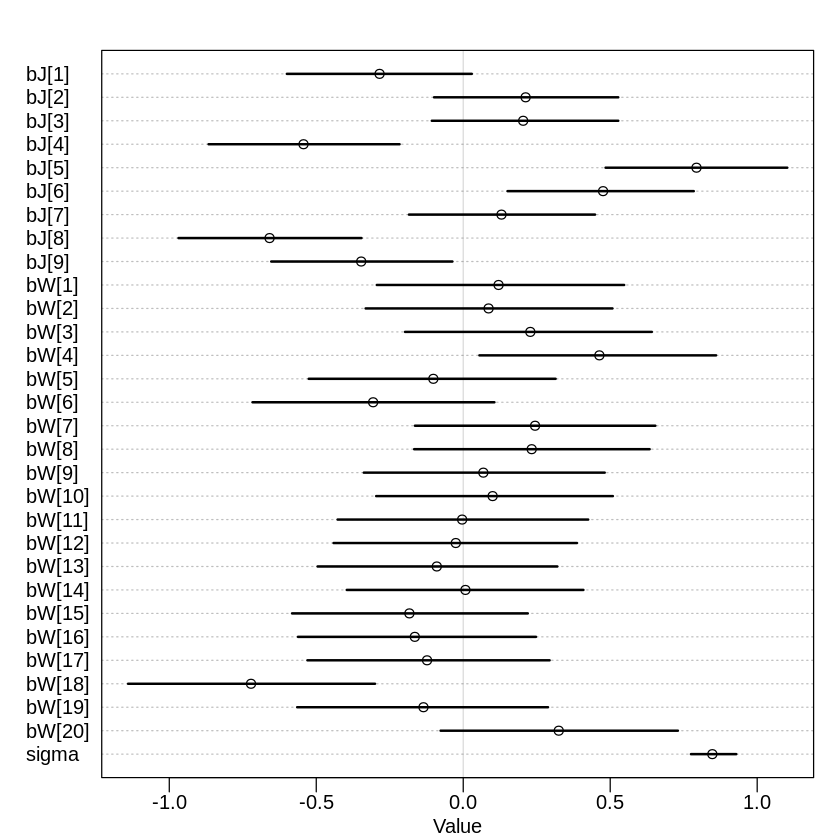

In [6]:
plot( precis( m1 , depth=2 ) )

The variation in 'biases' of the judges is greater than that of the wines!  Judge 4, 8 and 9 (and maybe 1) consistently score below average, while judges 5 and 6 score consistently above average.  Note that Judges 4, 8, 9 and 1 are 2 French and 2 American judges.  Judges 5 and 6 are both American.

Wine 4 appears to be the most highly rated wine, with wine 18 the lowest rated wine.

Waiting to draw page 2 of 2


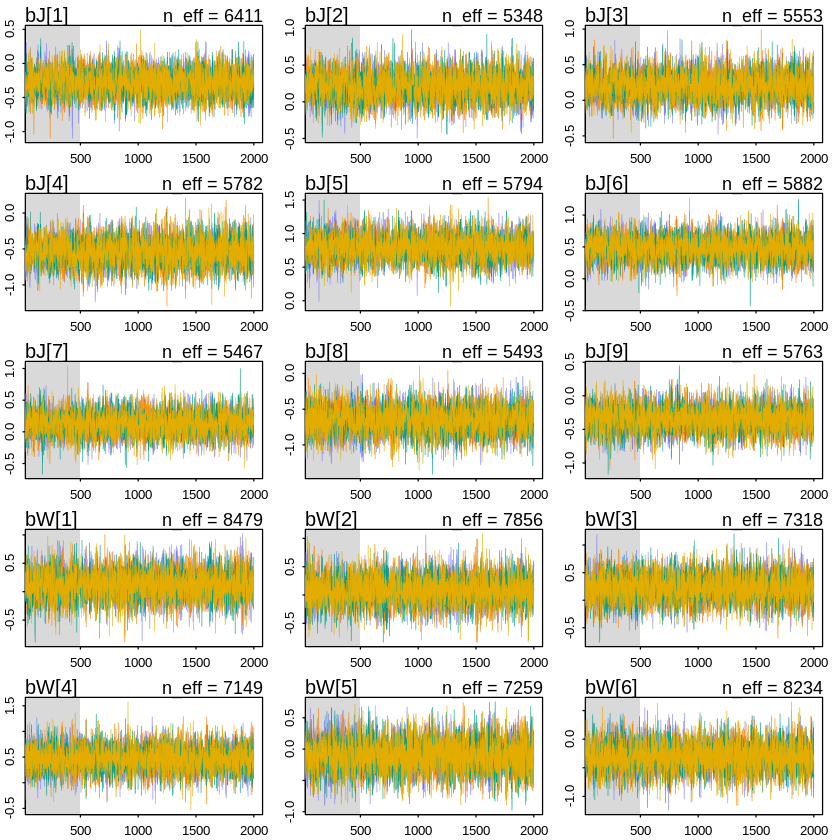

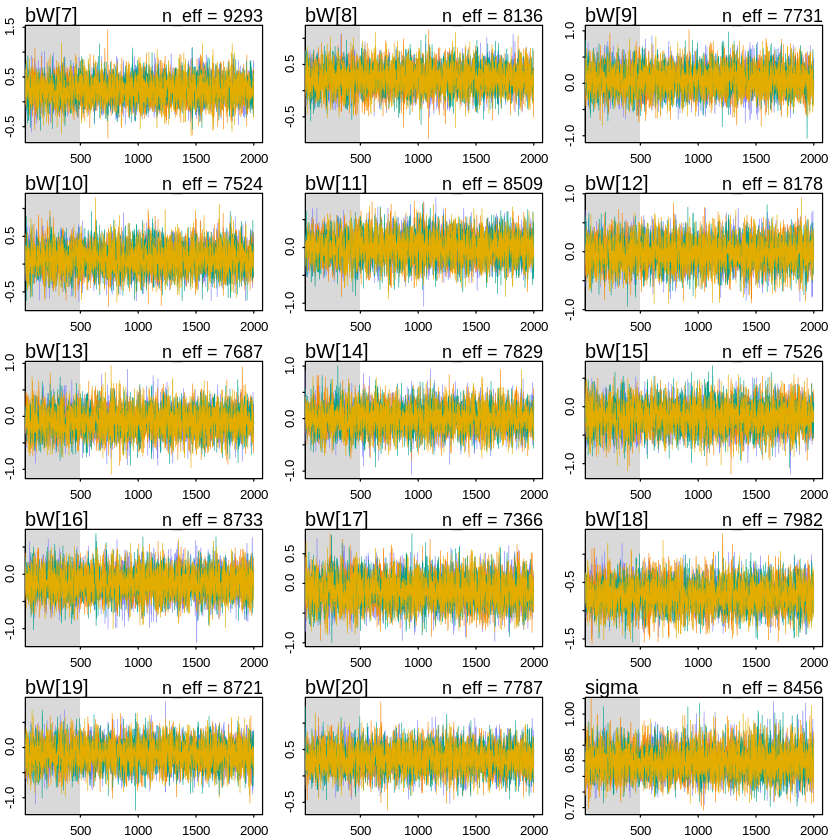

In [7]:
traceplot(m1)

Q2

In [8]:
d$fid <- as.integer(d$flight)
d$wa <- as.integer(d$wine.amer+1)
d$ja <- as.integer(d$judge.amer+1)

dat2 <- list(s=d$s, fid=d$fid, wa=d$wa, ja=d$ja)

In [9]:
m2 <- ulam(
        alist(
            s ~ dnorm(mu, sigma),
            mu <- bF[fid] + bWA[wa] + bJA[ja],
            bF[fid] ~ dnorm(0, 0.5),
            bWA[wa] ~ dnorm(0, 0.5),
            bJA[ja] ~ dnorm(0, 0.5),
            sigma ~ dexp(1)
        ), data = dat2
        , chains=4, cores=4
        )

The priors can be justified using the same arguments for Question 1, as in the score variable s is standardized, so has range -2 to 2.  Assume the categorical variables in dat2 are 'on average', except for one we are interested in, say wa[1].  It is possible that the presence of american wine (wa=2) could cause the score to move to +2 or -2, but it's unlikely that the judges would on average score in such an extreme way for all american ways (even though blind tasting).  So a standard deviation of 0.5 is justifiable, sd=1 is too much.

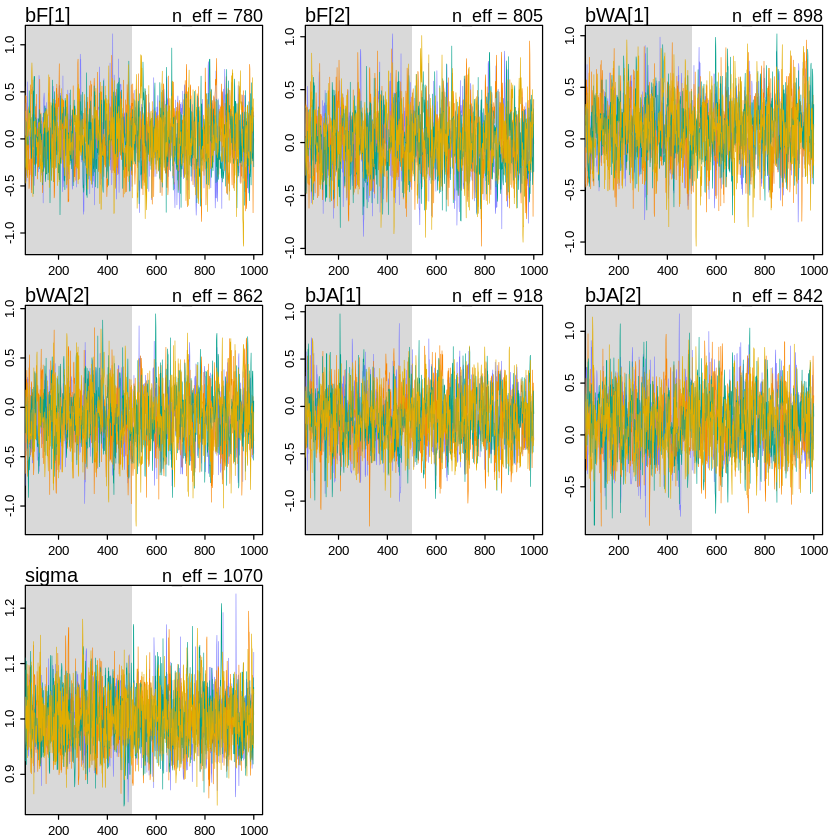

In [10]:
traceplot(m2)

The chains look fine.  As can be seen below, n_eff and Rhat also appear OK.

In [11]:
precis(m2, depth=2)

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bF[1],0.003952498,0.31097528,-0.4889993,0.5012940,779.5270,1.0000765
bF[2],0.009918483,0.30746361,-0.4824202,0.5049282,805.1914,1.0012238
bWA[1],0.084169454,0.30316857,-0.4081577,0.5807680,898.3501,1.0002534
bWA[2],-0.097302164,0.30331885,-0.5867864,0.3807640,861.6464,0.9993526
bJA[1],-0.119920055,0.29925997,-0.5931342,0.3602577,917.6957,0.9991313
bJA[2],0.124124308,0.30117970,-0.3394337,0.6094364,842.4683,1.0002924
sigma,0.999710046,0.05390408,0.9167363,1.0840579,1070.3380,1.0010325


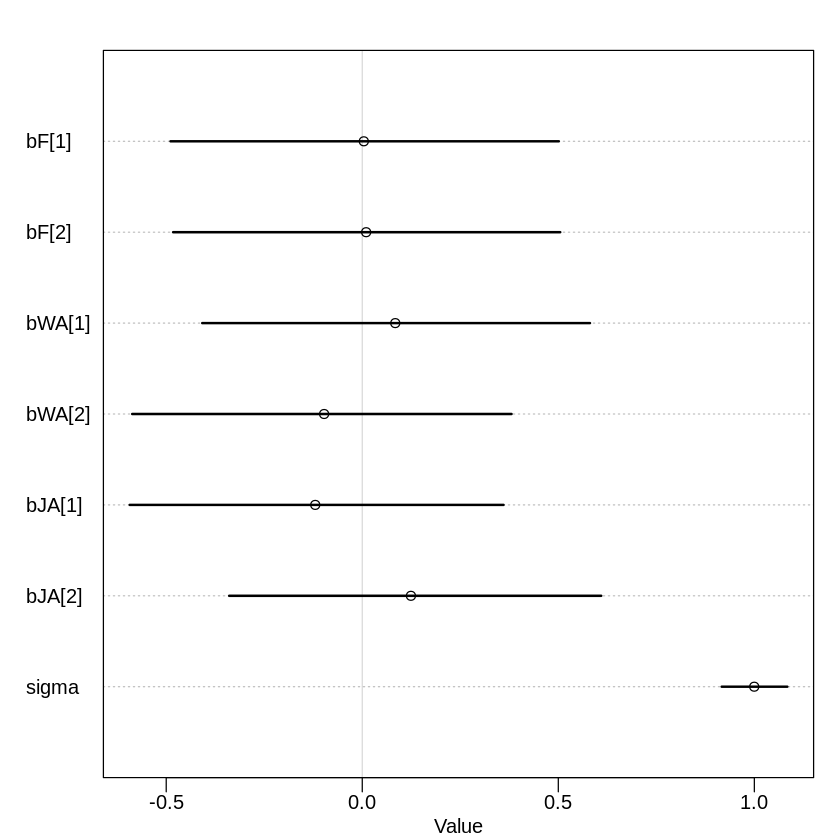

In [12]:
plot(precis(m2, depth=2))

The american judges are slightly more generous in scoring, and french wines do marginally better than the american wines, but there is not much in it.  There's practically no difference between red and white wines (the flight, bF, parameters).  Most of the variation is unexplained - captured in the 'sigma' parameter.

The contrast between American and French wines is:

In [13]:
post <- extract.samples(m2)
diff_w <- post$bWA[,2] - post$bWA[,1]
precis( diff_w )

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
diff_w,-0.1814716,0.147902,-0.4163165,0.05754819,▁▁▁▁▃▇▇▅▂▁▁


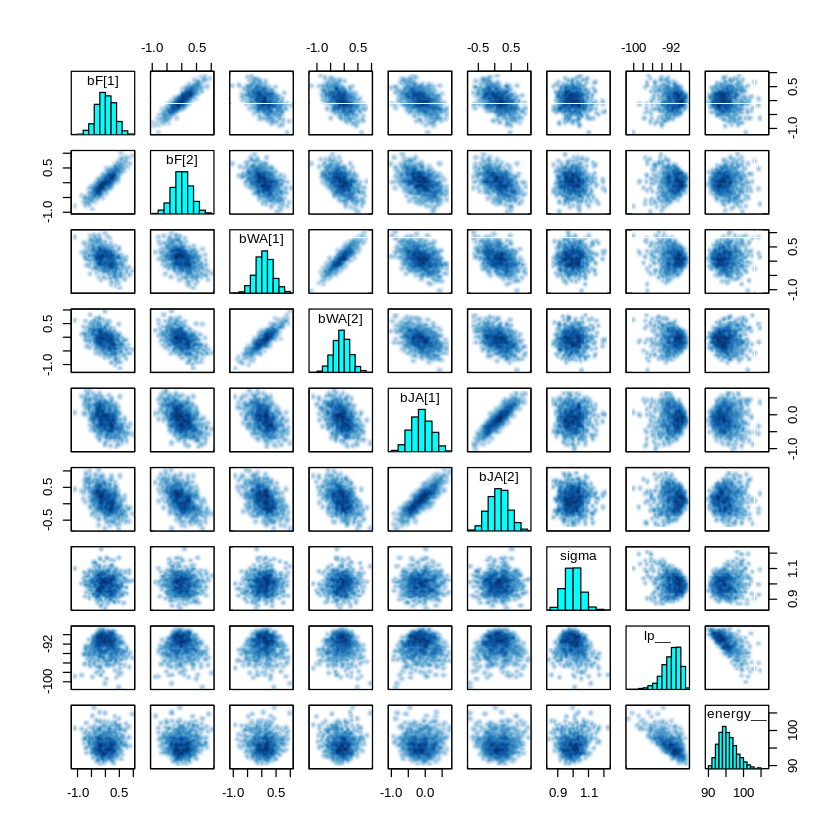

In [14]:
pairs(m2@stanfit)

Q3

From McElreath:

Now let’s do an index version. The way to think of this is to make unique
parameters for each combination. If we consider all the interactions — including
a three-way interaction between nation, judge and flight—there would be 8
combinations and so 8 parameters to estimate. Let’s go ahead and do that,
so we can simultaneously consider the 3-way interaction.
There are several ways to go about coding this. I’m going to use a trick and
make an array of parameters. An array is like a matrix, but can have more
than 2 dimensions. If we make a 2-by-2-by-2 array of parameters, then there
will be 8 parameters total and we can access each by just using these index
variables:

The interaction term meanings for the indicator version of the model:

w[2,1,2] (would be bFWA) - the expected change in the (sensititivity (i.e. change) of the standardized score to wine flight) due to the origin of the wine.... or
the expected change in the (sensititivity (i.e. change) of the standardized score to wine origin) due to the flight of the wine (i.e. when the wine is red or white).

w[1,2,2] (would be bFJA) - the expected change in the (sensititivity (i.e. change) of the standardized score to wine flight) due to the nationality of the judge.... or
the expected change in the (sensititivity (i.e. change) of the standardized score to judge nationality) due to the flight of the wine (i.e. when the wine is red or white).

w[2,2,1] (would be bWAJA) - the expected change in the (sensititivity (i.e. change) of the standardized score to wine origin) due to nationality of the judge.... or
the expected change in the (sensititivity (i.e. change) of the standardized score to judge nationality) due to the origin of the wine.


From McElreath: "I used the same priors as before for the main effects. I used tighter priors
for the interactions (in the indicator version, not index version of model). Why? Because interactions represent sub-categories
of data, and if we keep slicing up the sample, differences can’t keep getting
bigger. Again, the most important thing is not to use flat priors like Normal(0,10) that produce impossible outcomes."

For the index version of the model, the coefficients below represent the bias / average deviation from a standardized score of 0 due to the particular case of origin of wine, nationality of judge and flight of the wine.

w[wa, ja, fid].  Index is thus a tuple (wa, ja, fid).  Given the definitions in the data (1 = french, 2 = american for both wine (wa) and judges (ja), and flight id is 1 = red, 2 = white).  Thus:

w[1, 1, 1] == coefficient for french wine, french judge and red wine.

w[1, 1, 2] == coefficient for french wine, french judge and white wine.

w[1, 2, 1] == coefficient for french wine, american judge, red wine.

w[1, 2, 2] == coefficient for french wine, american judge, white wine.

w[2, 1, 1] == coefficient for american wine, french judge, red wine.

w[2, 1, 2] == coefficient for american wine, french judge, white wine.

w[2, 2, 1] == coefficient for american wine, american judge and red wine.

w[2, 2, 1] == coefficient for american wine, american judge and white wine.

In [15]:
m3b <- ulam(
            alist(
                s ~ dnorm( mu , sigma ),
                mu <- w[wa,ja,fid],
                real['2,2,2']:w ~ normal(0,0.5),      #The literal defines the multi dimensional matrix for w. McElreath wants to improve this definition in later versions of the rethinking libraries.
                sigma ~ dexp(1)
            ), data=dat2 
            , chains=4 , cores=4 
        )

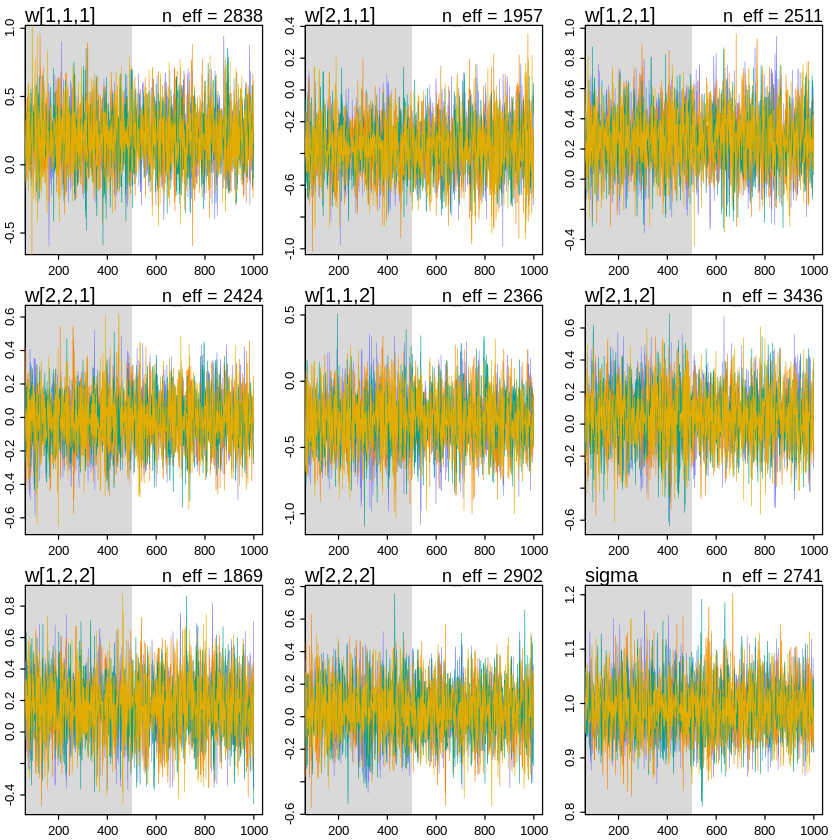

In [16]:
traceplot(m3b)

In [17]:
m3c <- ulam(
            alist(
                s ~ dnorm( mu , sigma ),
                mu <- w[wa,ja,fid],
                real['2,2,2']:w ~ dnorm(0,0.5),       #The literal defines the multi dimensional matrix for w. McElreath wants to improve this definition in later versions of the rethinking libraries.
                sigma ~ dexp(1)
            ), data=dat2 
            , chains=4 , cores=4 
        )

recompiling to avoid crashing R session


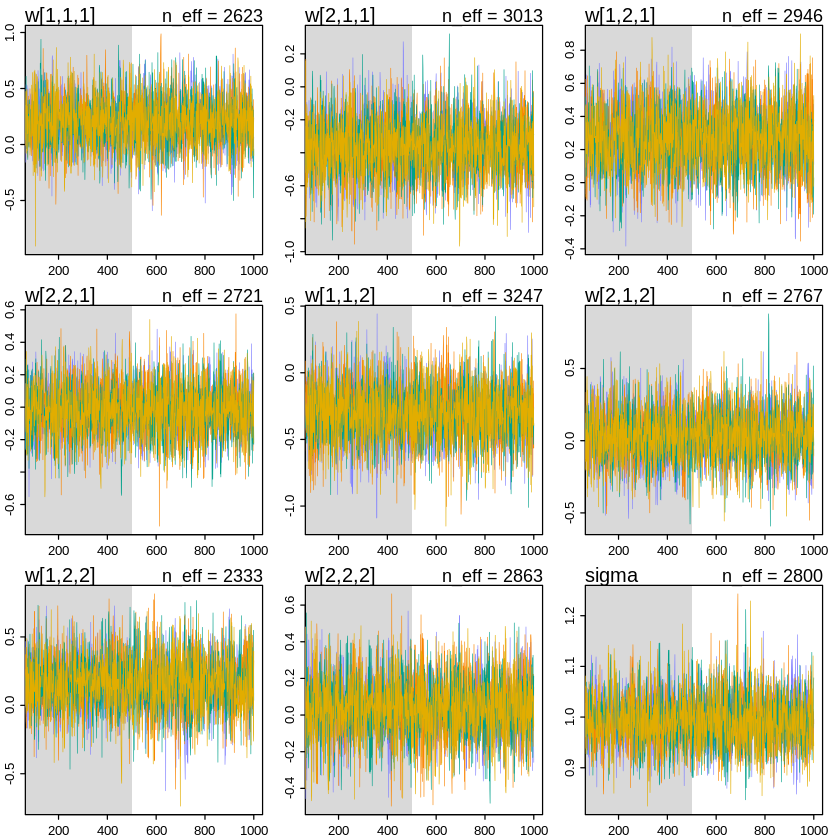

In [18]:
traceplot(m3c)

In [19]:
precis(m3b, depth=3)

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"w[1,1,1]",0.20200720,0.22116097,-0.15383092,0.55717935,2838.167,0.9986508
"w[1,1,2]",-0.29693227,0.21514569,-0.64348062,0.03888002,2366.337,0.9990812
"w[1,2,1]",0.27015562,0.20556351,-0.06098823,0.60048509,2510.968,0.9997147
"w[1,2,2]",0.15928685,0.20337152,-0.16982153,0.48312773,1868.982,0.9993036
"w[2,1,1]",-0.35858043,0.19138519,-0.65893044,-0.05289149,1957.023,0.9994238
"w[2,1,2]",0.03963709,0.18066410,-0.24767634,0.32557728,3436.048,0.9997221
"w[2,2,1]",-0.01461405,0.16696479,-0.28399887,0.25780018,2423.812,0.9987545
"w[2,2,2]",0.03436694,0.17049494,-0.23809969,0.30469263,2902.165,0.9996236
sigma,0.99021977,0.05277355,0.91065642,1.07631952,2740.848,0.9997512


In [20]:
precis(m3c, depth=3)

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"w[1,1,1]",0.20084862,0.23315851,-0.1707030,0.58635901,2622.654,0.9984410
"w[1,1,2]",-0.30651912,0.22381763,-0.6594109,0.04983622,3246.963,0.9991034
"w[1,2,1]",0.26532349,0.19960039,-0.0450641,0.58507431,2946.291,1.0019031
"w[1,2,2]",0.15878331,0.21434938,-0.1937827,0.50280689,2332.739,1.0005787
"w[2,1,1]",-0.36406097,0.18072581,-0.6472696,-0.07552868,3013.055,0.9993892
"w[2,1,2]",0.03733572,0.18647227,-0.2587250,0.33358985,2767.065,0.9985965
"w[2,2,1]",-0.01902443,0.16692908,-0.2957308,0.24345393,2720.610,0.9987212
"w[2,2,2]",0.03715904,0.17039326,-0.2398826,0.31035612,2862.899,0.9994791
sigma,0.99064167,0.05474674,0.9097957,1.08074382,2799.967,1.0016427


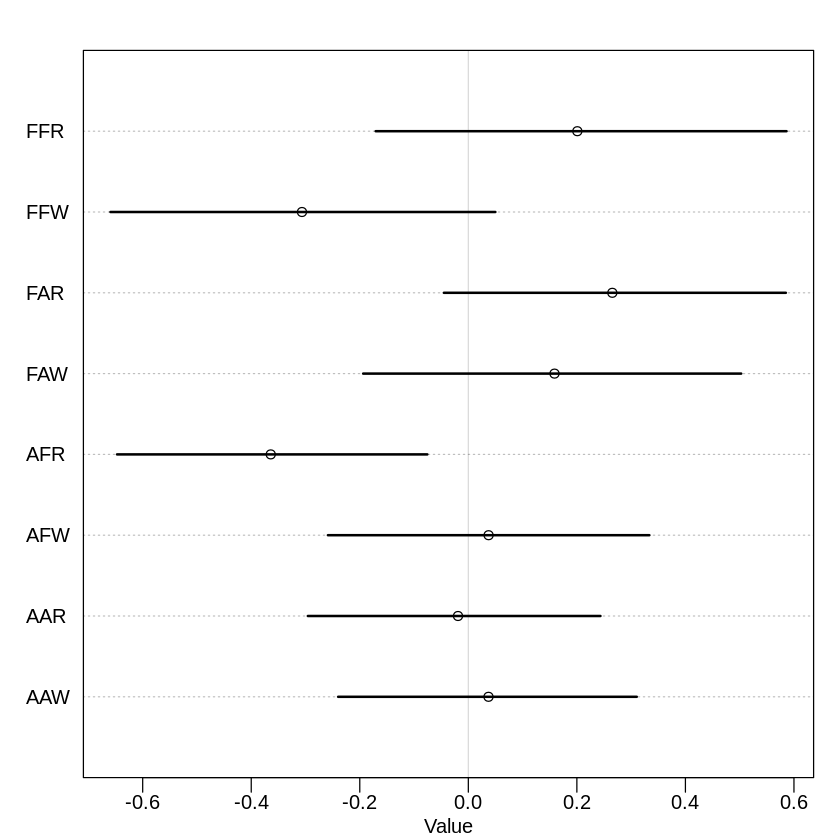

In [21]:
row_labels = c("FFR","FFW","FAR","FAW","AFR","AFW","AAR","AAW" )
plot( precis( m3c , depth=3 , pars="w" ) , labels=row_labels )

French white wines and American red wines that were judged by French judges (FFW, AFR) scored significantly worse than other cases (French reds, American whites, or American judges).

American judges tended to score French wines rather better than other cases, especially the red wines (FAR).

French judges have a bias in favour of French red wines (FFR).

Other cases aren't that significantly different from average.

Most of the variance in the scoring is unexplained though, with sigma the most significant parameter.

This gives greater detail to the insight from Q2, that American judges tend to score more generously than French judges.  Interestingly, American judges in fact score French wines higher than American ones on average.

In [29]:
pred_dat <- data.frame(
                wa = rep( 1:2 , times=4 ),
                ja = rep( 1:2 , each=4 ),
                fid = rep( c(1,1,2,2) , times=2 )
            )

In [30]:
pred_dat

wa,ja,fid
<int>,<int>,<dbl>
1,1,1
2,1,1
1,1,2
2,1,2
1,2,1
2,2,1
1,2,2
2,2,2


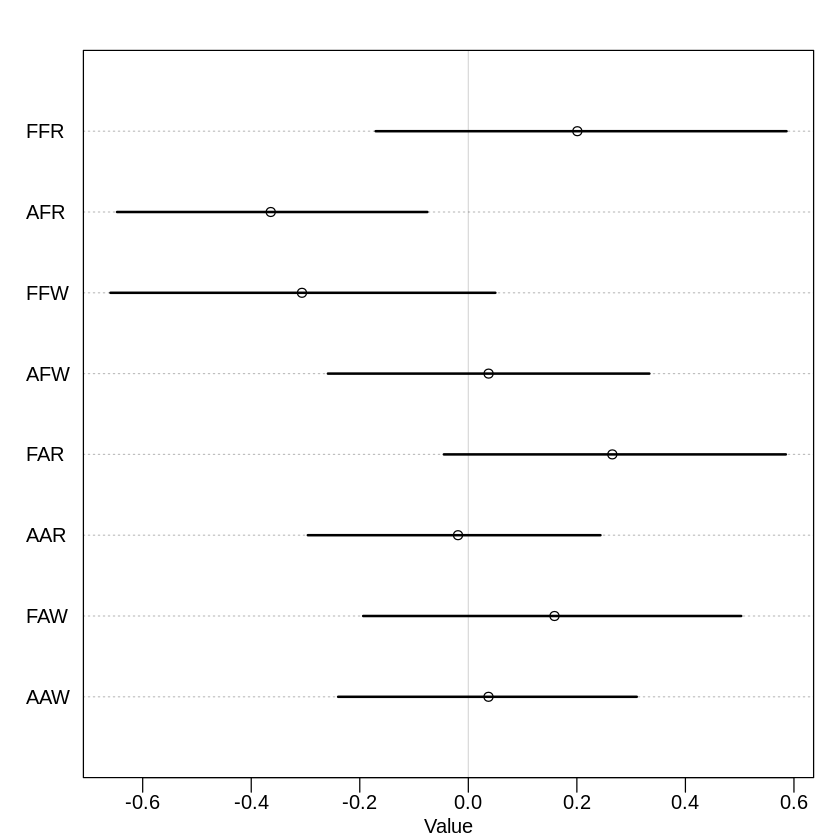

In [37]:
mu <- link( m3c , data=pred_dat )

row_labels <- paste( ifelse(pred_dat$wa==2,"A","F") ,
                        ifelse(pred_dat$ja==2,"A","F") ,
                        ifelse(pred_dat$fid==1,"R","W") , sep="" )

plot( precis( list(mu=mu) , depth=3 ) , labels=row_labels )
